In [1]:
import numpy as np
import jax.numpy as jnp
from jax import random, jit, jacfwd, vmap
from jax.numpy.linalg import inv
from jax.nn import tanh, sigmoid

from scipy.optimize import minimize
from scipy.stats import norm

import matplotlib.pyplot as plt

np.random.seed(123)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-ns5zg3ma because the default path (/home/jaron/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
# generate data 
n = 50
f = lambda x: .7*np.sin(5 * x) * (1 - np.tanh(x ** 2))

# precision of prior
alpha = 1.

# precision of noise
s = .1
beta = 1./s**2

x = np.linspace(-1., 1., n)
t = f(x) + s * np.random.randn(n) 

In [3]:
# analytical posterior 
basis = lambda x: jnp.array([1., x, x**2, x**3, x**4, x**5])
Phi = vmap(basis)(x)

# Hessian 
Sinv = alpha*np.eye(Phi.shape[1]) + beta * Phi.T @ Phi 
# Covariance
S = np.linalg.inv(Sinv)
# Mean 
m = beta * S @ Phi.T @ t

In [4]:
# posterior predictive distribution 
x_eval = np.linspace(-1.11, 1.11, 100)
Phi = vmap(basis)(x_eval)
t_hat = Phi@m
s_hat = np.sqrt(np.einsum('ni,ij,nj->n', Phi, S, Phi))

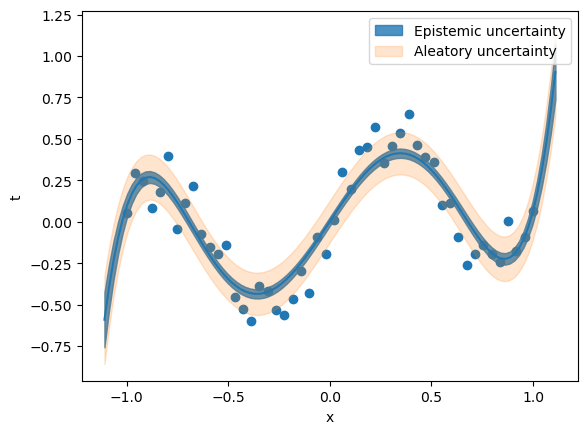

In [5]:
plt.scatter(x, t)
plt.plot(x_eval, t_hat)
plt.fill_between(x_eval, t_hat-s_hat, t_hat+s_hat, alpha=.8, color='C0', 
                 label='Epistemic uncertainty')
plt.fill_between(x_eval, t_hat-(s+s_hat), t_hat+s+s_hat, alpha=.2, color='C1', 
                 label='Aleatory uncertainty')
plt.legend()
plt.xlabel("x")
plt.ylabel("t")
plt.show()

In [6]:
# goal is to use a neural network to map Gaussian noise to samples from posterior parameter distribution

In [7]:
# define model that takes in unknown parameters (latent variables)
@jit
def model(x, z):
    
    a, b, c, d, e, f = z
    
    return a + b*x + c*x**2 + d*x**3 + e*x**4 + f*x**5

# gradient of model w.r.t. parameters
grad_model = jit(jacfwd(model, 1))

# problem dimension
d = 6

# determine shapes of weights/biases = [w, b]
shapes = [[d], [d], [d], [d], [d], [d]]
k_params = []
n_params = 0
for shape in shapes:
    k_params.append(n_params)
    n_params += np.prod(shape)
k_params.append(n_params)

# initialize parameters
lmbda = .5*np.random.randn(n_params)

# reshape parameters into weight matrices and bias vectors
def reshape(params):
    # params is a vector = [Wih, bih, Who, bho]
    return [np.reshape(params[k1:k2], shape) for k1, k2, shape in
            zip(k_params, k_params[1:], shapes)]

@jit
def nn(y, lmbda):
    
    # weights and biases of nn
    w1, b1, w2, b2, w3, b3 = reshape(lmbda)
    
    # hidden layer
    h = tanh(jnp.einsum('i,...i->...i', w1, y) + b1)
    
    # hidden layer
    h = tanh(jnp.einsum('i,...i->...i', w2, h) + b2)
    
    # output
    z = jnp.einsum('i,...i->...i', w3, h) + b3
    
    return z

# gradient of nn output w.r.t. parameters
grad_nn = jit(jacfwd(nn, 1))

@jit 
def inv_nn(z, lmbda):
    
    # weights and biases of nn
    w1, b1, w2, b2, w3, b3 = reshape(lmbda)
    
    # hidden layer
    h = jnp.einsum('i,...i->...i', 1./w3, z - b3)

    # input 
    h = jnp.einsum('i,...i->...i', 1./w2, jnp.arctanh(h) - b2)
    
    # input 
    y = jnp.einsum('i,...i->...i', 1./w1, jnp.arctanh(h) - b1)

    return y  
    
# gradient of nn output w.r.t. parameters
jac_nn = jit(jacfwd(nn, 0))
jac_nn_inv = jit(jacfwd(inv_nn, 0))

@jit
def log_abs_det(yi, lmbda):
    # return jnp.log(jnp.abs(jnp.linalg.det(jac_nn(yi, lmbda))))
    return jnp.sum(jnp.log(jnp.abs(jnp.diag(jac_nn(yi, lmbda)))))

# gradient of entropy of approximating distribution w.r.t. lmbda
grad_log_abs_det = jit(jacfwd(log_abs_det, 1))

In [8]:
y = np.random.randn(1, d)
y

array([[-0.73246199, -1.21252313,  2.08711336,  0.16444123,  1.15020554,
        -1.26735205]])

In [9]:
inv_nn(nn(y, lmbda), lmbda)

Array([[-0.7324629 , -1.21252   ,  2.0871534 ,  0.16444167,  1.1500978 ,
        -1.2673508 ]], dtype=float32)

In [10]:
# ELBO cost function 
def elbo(lmbda, n_sample=1000):
    
    # use nn to sample parameters
    # y = np.random.random(size=[n_sample, d])
    y = np.random.randn(n_sample, d)
    z = nn(y, lmbda)
    
    # evaluate model fitness 
    ELBO = 0.
    for yi, zi in zip(y, z):
        # likelihood
        ELBO += beta * np.sum((t - model(x, zi))**2) / 2. / n_sample
        # prior
        ELBO += alpha * np.sum(zi**2) / 2. / n_sample
        # entropy
        ELBO -= log_abs_det(yi, lmbda) / n_sample
    
    return ELBO

# gradient of ELBO cost function
def grad_elbo(lmbda, n_sample=1000):
    
    # use nn to sample parameters
    # y = np.random.random(size=[n_sample, d])
    y = np.random.randn(n_sample, d)
    z = nn(y, lmbda)
    
    # gradient 
    grad_ELBO = 0.
    grad_nn_eval = grad_nn(y, lmbda)
    for gi, zi, yi in zip(grad_nn_eval, z, y):
        # likelihood
        grad_ELBO += beta * np.einsum('t,ti,ij->j', model(x, zi) - t, grad_model(x, zi), gi) / n_sample
        # prior 
        grad_ELBO += alpha * np.einsum('i,ij->j', zi, gi) / n_sample
        # entropy
        grad_ELBO -= grad_log_abs_det(yi, lmbda) / n_sample
    
    return grad_ELBO

In [11]:
# make sure NN is flexible enough to capture true posterior

# nll of true posterior
@jit 
def neg_log_likelihood(yi, lmbda):
    zi = nn(yi, lmbda)
    return jnp.einsum('i,ij,j', m-zi, Sinv, m-zi) / 2.
grad_neg_log_likelihood = jit(jacfwd(neg_log_likelihood, 1))

# kl divergence btw q(lmbda) and p(z | X)
def kl(lmbda, n_sample=1000):
    
    # use nn to sample parameters
    # y = np.random.random(size=[n_sample, d])
    y = np.random.randn(n_sample, d)
    z = nn(y, lmbda)
    
    # evaluate model fitness 
    KL = 0.
    for yi, zi in zip(y, z):
        # divergence btw true posterior
        KL += neg_log_likelihood(yi, lmbda) / n_sample
        # entropy
        KL -= log_abs_det(yi, lmbda) / n_sample
        
    return KL

# make sure NN is flexible enough to capture true posterior
def grad_kl(lmbda, n_sample=1000):
    
    # use nn to sample parameters
    # y = np.random.random(size=[n_sample, d])
    y = np.random.randn(n_sample, d)
    z = nn(y, lmbda)
    
    grad_KL = 0.
    for yi, zi in zip(y, z):
        grad_KL += grad_neg_log_likelihood(yi, lmbda) / n_sample
        grad_KL -= grad_log_abs_det(yi, lmbda) / n_sample
        
    return grad_KL

In [12]:
# callback
def callback(x):
    print("KL: {:.3f}, ELBO: {:.3f}".format(kl(x, n_sample=100), elbo(x, n_sample=100)))

In [13]:
res = minimize(fun=elbo,
               jac=grad_elbo,
               x0=lmbda,
               method='BFGS', 
               callback=callback)

lmbda = res.x

KL: 420.817, ELBO: 488.744
KL: 325.141, ELBO: 404.962
KL: 237.172, ELBO: 306.911
KL: 185.917, ELBO: 255.883
KL: 178.514, ELBO: 249.059
KL: 163.764, ELBO: 232.621
KL: 137.826, ELBO: 208.210
KL: 102.450, ELBO: 173.378
KL: 86.264, ELBO: 150.592
KL: 41.547, ELBO: 112.873
KL: 33.733, ELBO: 103.320
KL: 30.112, ELBO: 100.394
KL: 29.403, ELBO: 99.521
KL: 27.528, ELBO: 98.551
KL: 27.076, ELBO: 98.198
KL: 26.744, ELBO: 97.473
KL: 26.695, ELBO: 96.788
KL: 26.884, ELBO: 96.967
KL: 26.554, ELBO: 96.695
KL: 26.652, ELBO: 96.764
KL: 26.214, ELBO: 96.460
KL: 25.720, ELBO: 95.838
KL: 25.695, ELBO: 95.627
KL: 24.513, ELBO: 95.327
KL: 24.885, ELBO: 95.326
KL: 24.662, ELBO: 95.034
KL: 24.193, ELBO: 94.979
KL: 24.835, ELBO: 95.478
KL: 24.458, ELBO: 94.994
KL: 24.312, ELBO: 94.961
KL: 24.703, ELBO: 95.302


In [14]:
# sample noise
# y = np.random.random(size=[1000, d])
y = np.random.randn(1000, d)
z = nn(y, lmbda)

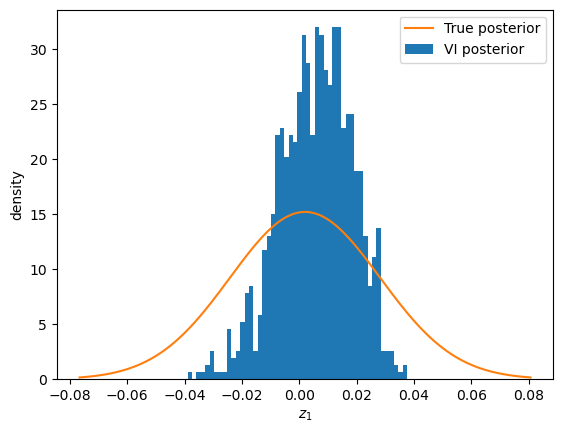

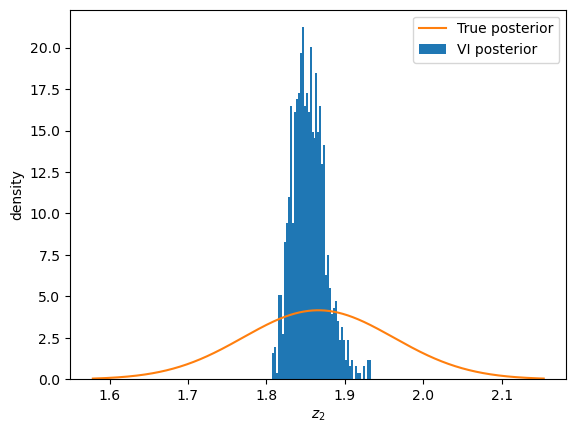

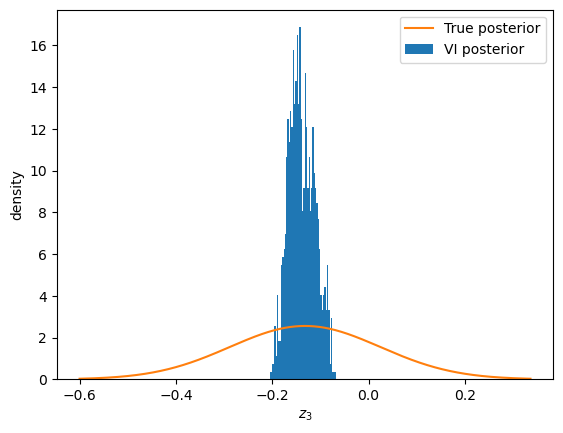

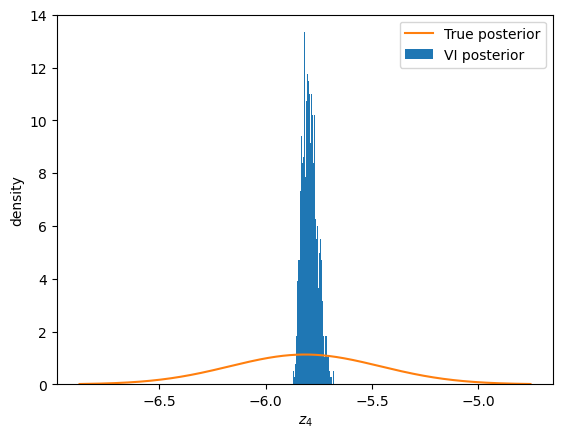

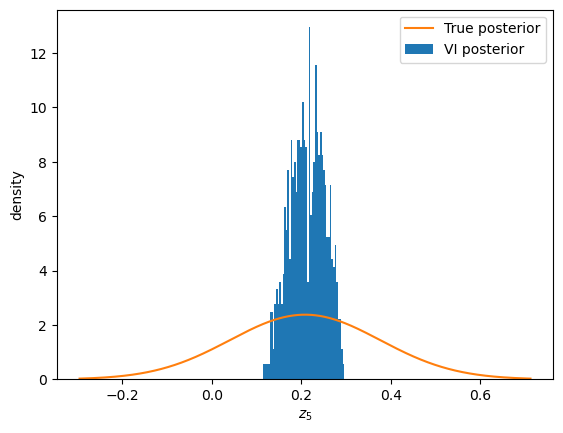

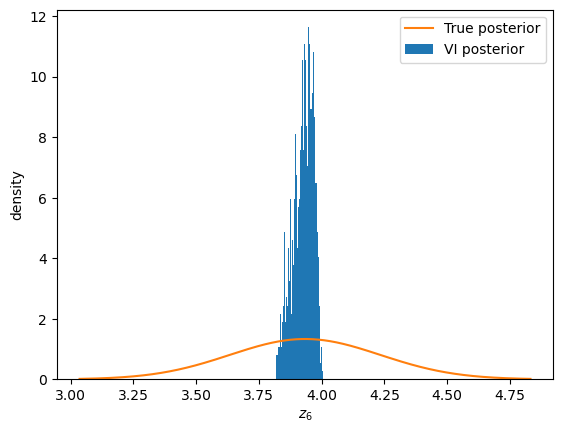

In [15]:
for i, (mean, variance) in enumerate(zip(m, np.diag(S))):

    # Generate data points for x-axis
    x_vals = np.linspace(mean - 3 * np.sqrt(variance), mean + 3 * np.sqrt(variance), 1000)

    # Calculate the corresponding probability density function (PDF) values
    pdf_values = norm.pdf(x_vals, mean, np.sqrt(variance))
    plt.plot(x_vals, pdf_values, c='C1', label='True posterior')
    
    # plot NN posterior 
    plt.hist(np.array(z[:, i]), color='C0', bins=50, density=True, label='VI posterior')
    
    plt.xlabel(f"$z_{i+1}$")
    plt.ylabel("density")
    plt.legend()
    plt.show()

In [16]:
# plot posterior predictive 
t_samples = vmap(model, (None, 0))(x_eval, z)
t_hat = np.mean(t_samples, 0)
s_hat = np.std(t_samples, 0)

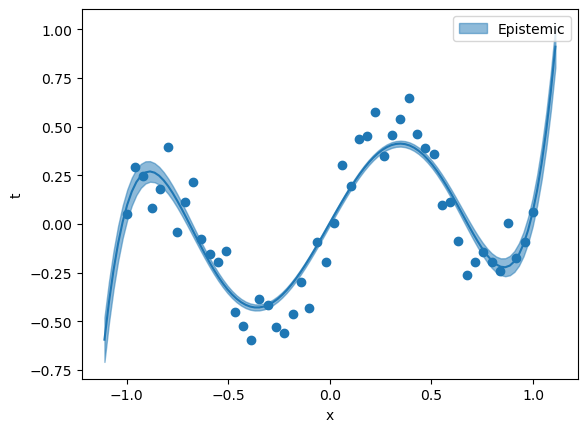

In [17]:
plt.scatter(x, t)
plt.plot(x_eval, t_hat)
plt.fill_between(x_eval, t_hat-s_hat, t_hat+s_hat, alpha=.5, color='C0', label='Epistemic')
plt.xlabel("x")
plt.ylabel("t")
plt.legend()
plt.show()